611.2126978267946
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


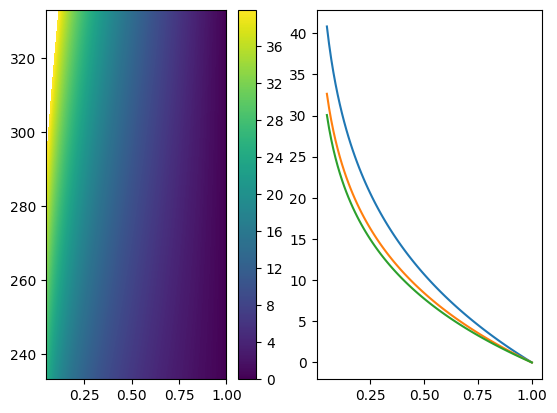

In [2]:
import numpy
import numpy as np
import pandas
import pandas as pd
from numba import njit
import sys,glob
import zipfile, os, time
import urllib3
from datetime import datetime, timedelta
import glob
import h5py
import netCDF4 as nc
sys.path.append(os.getcwd()+'/../cds-backend/code/')
sys.path.append(os.getcwd()+'/../harvest/code/')
import rasotools
# from harvest_convert_to_netCDF_newfixes import write_dict_h5
import cds_eua3 as eua
# eua.logging_set_level(30)
import xarray as xr

import cdsapi, zipfile, os, time
#import schedule
import copy
from shutil import copyfile
import multiprocessing
import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab
import warnings
warnings.filterwarnings('ignore')

from inspect import getmembers, isfunction


In [54]:
# lowres = glob.glob('/mnt/jetfs/scratch/uvoggenberger/rttov_out/gpsro_20231114/*.nc')
highres = glob.glob('/mnt/jetfs/scratch/uvoggenberger/rttov_out/gpsro_all_levels/*.nc')

In [70]:
print(highres[0])
df = xr.open_dataset(highres[0], decode_times=False).to_dataframe()
df.datum.drop_duplicates()[0,0,0,0,0]


/mnt/jetfs/scratch/uvoggenberger/rttov_out/gpsro_all_levels/bt2_10x10-2007-03-01_2007-04-01-RO_OPSv5.6.2daily_L2b-data.nc


39140.0

In [7]:
# time_series = {}
# for targetlon in range(-180,185,5):
#     for targetlat in range(-90,95,5):
#         time_series[str(targetlat) + '_' + str(targetlon)] = [[],[],[],[]]

# for date in lowres[:]:
#     df = xr.open_dataset(date, decode_times=False).to_dataframe()
#     sel_df = df.loc(axis=0)[:, :, [0], :, [0]]
#     for lat_lon in sel_df.drop_duplicates(['lat', 'lon'])[['lat', 'lon']].values:
#         single_df = sel_df[np.logical_and(sel_df.lat == lat_lon[0], sel_df.lon == lat_lon[1])]
#         # display(single_df)
#         ts_index = str(int(lat_lon[0])) + '_' + str(int(lat_lon[1]))
#         time_series[ts_index][0].append(single_df[single_df.press == 2].montemp.values)
#         time_series[ts_index][1].append(single_df[single_df.press == 3].montemp.values)
#         time_series[ts_index][2].append(single_df[single_df.press == 4].montemp.values)
#         time_series[ts_index][3].append(single_df[single_df.press == 2].datum.values)

# trends_ch3 = {}
# trends_ch4 = {}
# trends_ch5 = {}
# for lat_lon in time_series.keys():
#     if len(time_series[lat_lon][0]) < 1:
#         continue
#     df = pandas.DataFrame(np.transpose(
#         [np.array(time_series[lat_lon][0]).flatten(), 
#          np.array(time_series[lat_lon][1]).flatten(), 
#          np.array(time_series[lat_lon][2]).flatten(), 
#          np.array(time_series[lat_lon][3]).flatten(), 
#          [int(lat_lon.split('_')[0])]*len(time_series[lat_lon][0]), 
#          [int(lat_lon.split('_')[1])]*len(time_series[lat_lon][0])]
#          ), columns=['ch3', 'ch4', 'ch5', 'time', 'lat', 'lon'])
#     df.time = [pd.to_datetime('1900-01-01') + pd.Timedelta(x, 'd') for x in df.time]
#     filter_array = np.abs(df.ch3 - df.ch4) < 0.5
#     df.ch3[filter_array] = np.nan
#     df.ch4[filter_array] = np.nan
#     df.ch5[filter_array] = np.nan
#     df = df.dropna()

#     xdf = df.set_index(['lat', 'lon', 'time']).to_xarray()
#     trends_ch3[lat_lon] = (rasotools.met.time.trend(xdf.ch3,only_slopes=True)*len(df.time)*12.*10.)
#     trends_ch4[lat_lon] = (rasotools.met.time.trend(xdf.ch4,only_slopes=True)*len(df.time)*12.*10.)
#     trends_ch5[lat_lon] = (rasotools.met.time.trend(xdf.ch5,only_slopes=True)*len(df.time)*12.*10.)

# pickle.dump( trends_ch3, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/gpsro_worldmap/gpsro_ch2.p", "wb" ) )
# pickle.dump( trends_ch4, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/gpsro_worldmap/gpsro_ch3.p", "wb" ) )
# pickle.dump( trends_ch5, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/gpsro_worldmap/gpsro_ch4.p", "wb" ) )

In [9]:
# time_series = {}
# for targetlon in range(-180,185,5):
#     for targetlat in range(-90,95,5):
#         time_series[str(targetlat) + '_' + str(targetlon)] = [[],[],[],[]]

# for date in highres[:]:
#     df = xr.open_dataset(date, decode_times=False).to_dataframe()
#     sel_df = df.loc(axis=0)[:, :, [0], :, [0]]
#     for lat_lon in sel_df.drop_duplicates(['lat', 'lon'])[['lat', 'lon']].values:
#         single_df = sel_df[np.logical_and(sel_df.lat == lat_lon[0], sel_df.lon == lat_lon[1])]
#         # display(single_df)
#         ts_index = str(int(lat_lon[0])) + '_' + str(int(lat_lon[1]))
#         time_series[ts_index][0].append(single_df[single_df.press == 2].montemp.values)
#         time_series[ts_index][1].append(single_df[single_df.press == 3].montemp.values)
#         time_series[ts_index][2].append(single_df[single_df.press == 4].montemp.values)
#         time_series[ts_index][3].append(single_df[single_df.press == 2].datum.values)

# trends_ch3 = {}
# trends_ch4 = {}
# trends_ch5 = {}
# for lat_lon in time_series.keys():
#     if len(time_series[lat_lon][0]) < 1:
#         continue
#     df = pandas.DataFrame(np.transpose(
#         [np.array(time_series[lat_lon][0]).flatten(), 
#          np.array(time_series[lat_lon][1]).flatten(), 
#          np.array(time_series[lat_lon][2]).flatten(), 
#          np.array(time_series[lat_lon][3]).flatten(), 
#          [int(lat_lon.split('_')[0])]*len(time_series[lat_lon][0]), 
#          [int(lat_lon.split('_')[1])]*len(time_series[lat_lon][0])]
#          ), columns=['ch3', 'ch4', 'ch5', 'time', 'lat', 'lon'])
#     df.time = [pd.to_datetime('1900-01-01') + pd.Timedelta(x, 'd') for x in df.time]
#     filter_array = np.abs(df.ch3 - df.ch4) < 0.5
#     df.ch3[filter_array] = np.nan
#     df.ch4[filter_array] = np.nan
#     df.ch5[filter_array] = np.nan
#     df = df.dropna()

#     xdf = df.set_index(['lat', 'lon', 'time']).to_xarray()
#     trends_ch3[lat_lon] = (rasotools.met.time.trend(xdf.ch3,only_slopes=True)*len(df.time)*12.*10.)
#     trends_ch4[lat_lon] = (rasotools.met.time.trend(xdf.ch4,only_slopes=True)*len(df.time)*12.*10.)
#     trends_ch5[lat_lon] = (rasotools.met.time.trend(xdf.ch5,only_slopes=True)*len(df.time)*12.*10.)

# pickle.dump( trends_ch3, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/gpsro_worldmap/gpsro_ch2_highres.p", "wb" ) )
# pickle.dump( trends_ch4, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/gpsro_worldmap/gpsro_ch3_highres.p", "wb" ) )
# pickle.dump( trends_ch5, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/gpsro_worldmap/gpsro_ch4_highres.p", "wb" ) )

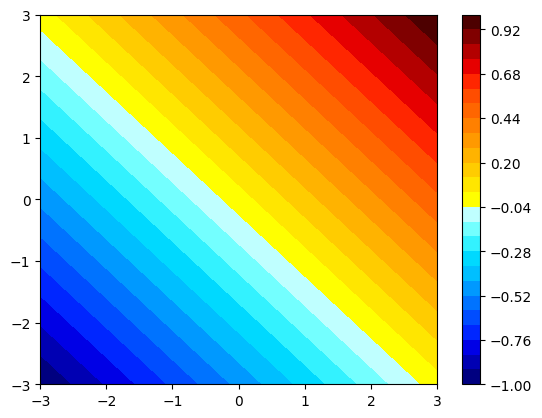

ready


In [10]:
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import numpy

def rgb(r,g,b):
    return tuple(numpy.asarray([r,g,b],dtype=numpy.float))

def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    se = [(None,) * 3, 0.0]
    for s in seq:
        se.append(s[0])
        se.append(s[1])#+ list(seq) +
        seq=se+[ (None,) * 3]
        cdict = {'red': [], 'green': [], 'blue': []}
        for i, item in enumerate(seq):
            if isinstance(item, float):
                r1, g1, b1 = seq[i - 1]
                r2, g2, b2 = seq[i + 1]
                cdict['red'].append([item, r1, r2])
                cdict['green'].append([item, g1, g2])
                cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

rgblist=["rgb(0,0,0.3)", "rgb(0,0,0.5)",
"rgb(0,0,0.7)", "rgb(0,0,0.9)", "rgb(0,0.15,1)",
"rgb(0,0.3,1)", "rgb(0,0.45,1)", "rgb(0,0.6,1)",
"rgb(0,0.75,1)", "rgb(0,0.85,1)", "rgb(0.2,0.95,1)",
"rgb(0.45,1,1)", "rgb(0.75,1,1)", "rgb(1,1,0)",
"rgb(1,0.9,0)", "rgb(1,0.8,0)", "rgb(1,0.7,0)",
"rgb(1,0.6,0)", "rgb(1,0.5,0)", "rgb(1,0.4,0)",
"rgb(1,0.3,0)", "rgb(1,0.15,0)", "rgb(0.9,0,0)",
"rgb(0.7,0,0)", "rgb(0.5,0,0)", "rgb(0.3,0,0)"]
rgblist2=zip([eval(rgblist[l]) for l in range(len(rgblist))],numpy.linspace(0,1,len(rgblist)))

cmnew=make_colormap(rgblist2)

x,y=numpy.meshgrid(numpy.linspace(-3,3,101),numpy.linspace(-3,3,101))
gauss=x/6+y/6
clist=numpy.linspace(-1,1,26)
plt.contourf(x,y,gauss,clist,cmap=cmnew)
plt.colorbar()
plt.show()
print('ready')

In [21]:
def plt_trends(lla,pdict,var='_',bias='_', marker_size = 510, marker_shape = 's', alpha=0.8):
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (12, 8),
             'axes.labelsize': 'x-large',
             'axes.titlesize': 20,
             'xtick.labelsize':'medium',
             'ytick.labelsize':'medium'}
    pylab.rcParams.update(params)

    if 'scale' not in pdict.keys():
        pdict['scale']=1.0
    a = rasotools.plot._helpers.cost(lla[2],lla[1],lla[0])
    cost = np.sum(a)/len(a)

    ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
    ax._autoscaleXon = False
    ax._autoscaleYon = False

    ax.add_feature(cfeature.OCEAN, zorder=0)
    ax.coastlines()

    plt.scatter(lla[2], lla[1], s=marker_size, alpha=alpha,
                c= lla[0],
                cmap=cmnew,
                vmin=-pdict['scale'],
                vmax=pdict['scale'],
                marker = marker_shape,
                edgecolor='k',)
    plt.colorbar(orientation='horizontal', label='Trend '+pdict['units'], shrink=0.9, pad=0.05)
    plt.tight_layout()
    plt.title('Brightness Temperature ' + str(pdict['start'])+'-'+str(pdict['stop'])+', '+str(pdict['pl'])+'\n'+'trend heterogeneity cost function: '+'{:.2f}'.format(cost)+'\n'+'number of stations: '+str(len(lla[0])))
        
    try:
        os.mkdir('plots_new')
    except:
        pass
#     plt.savefig('plots_new/cuon_'+names[bias]+'_'+str(pdict['start'])+'-'+str(pdict['stop'])+'_'+str(pdict['pl']), bbox_inches='tight')
    plt.show()
    plt.close()




In [22]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
plt.rcParams['figure.figsize'] = [12, 8]

def plot_world_map(file, mission_channel, marker_size = 510, marker_shape = 's', alpha = 0.8):
    trends = pickle.load( open( file, "rb" ) )
    lats = []
    lons = []
    vals = []
    minl = []
    maxl =[]

    for i in trends:
        if trends[i] >= 15:
            maxl.append([i, trends[i]])
        elif trends[i] <= -15:
            minl.append([i, trends[i]])
        else:
            lats.append(float(trends[i].lat))
            lons.append(float(trends[i].lon))
            vals.append(float(trends[i].values))
    print(' --- dropped ---')
    print(maxl)
    print(minl)
    # /10. for K/10a
    plt_trends(np.array([np.array(vals)/10., np.array(lats), np.array(lons)]), dict(var='temperature',pl=mission_channel,start='2007',stop='2020',units=r'K/10a'), marker_size = marker_size, marker_shape = marker_shape, alpha=alpha)
#     rasotools.plot.map.points(lon=np.array(lons), lat=np.array(lats), values=np.array(vals), vmin=-5, vmax=5)
    plt.show()
    plt.close()

In [16]:
# for k in ['ch2', 'ch3', 'ch4']:
#     files = glob.glob('/users/staff/uvoggenberger/scratch/RTTOV_output/gpsro_worldmap/old/*'+k+'.p')
#     files = np.sort(files)
#     for i in files:
#         plot_world_map(i, i.split('/')[-1].split('.')[0])


 --- dropped ---
[]
[]


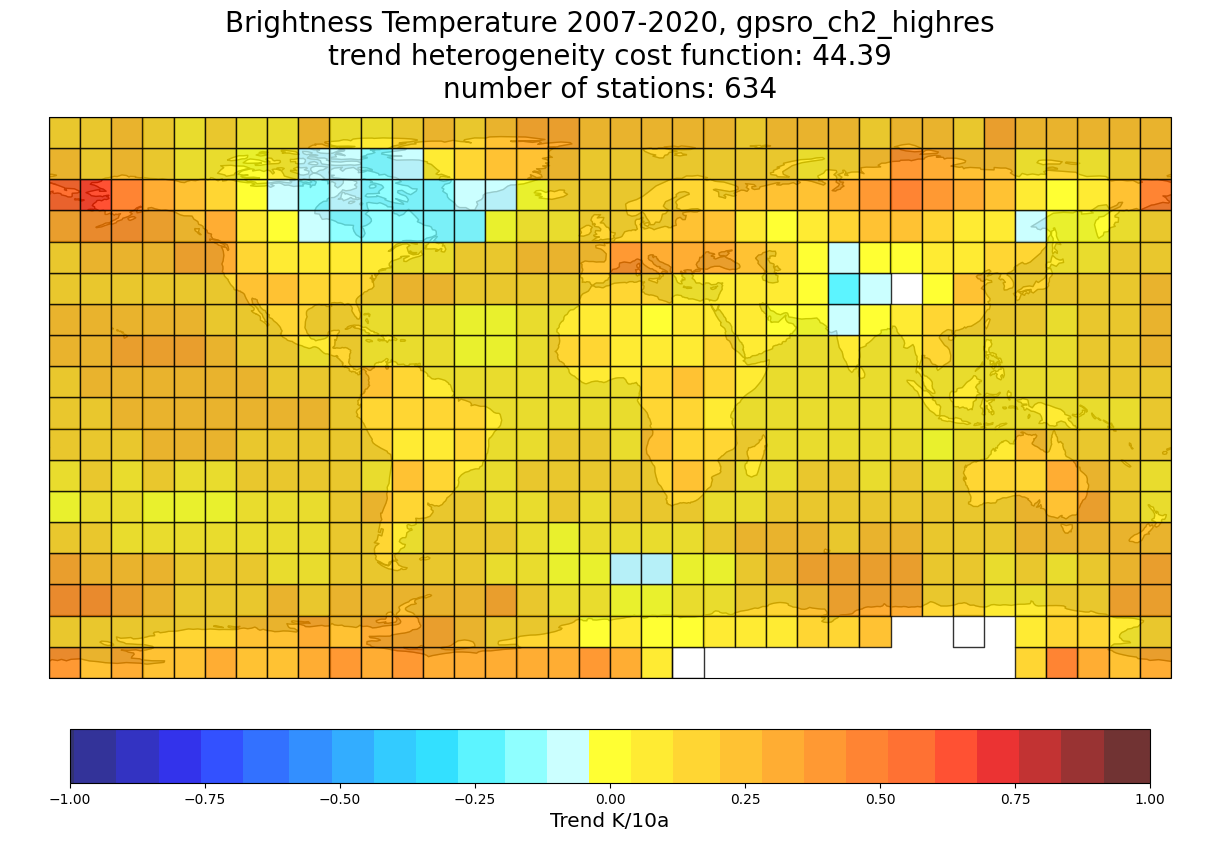

 --- dropped ---
[]
[]


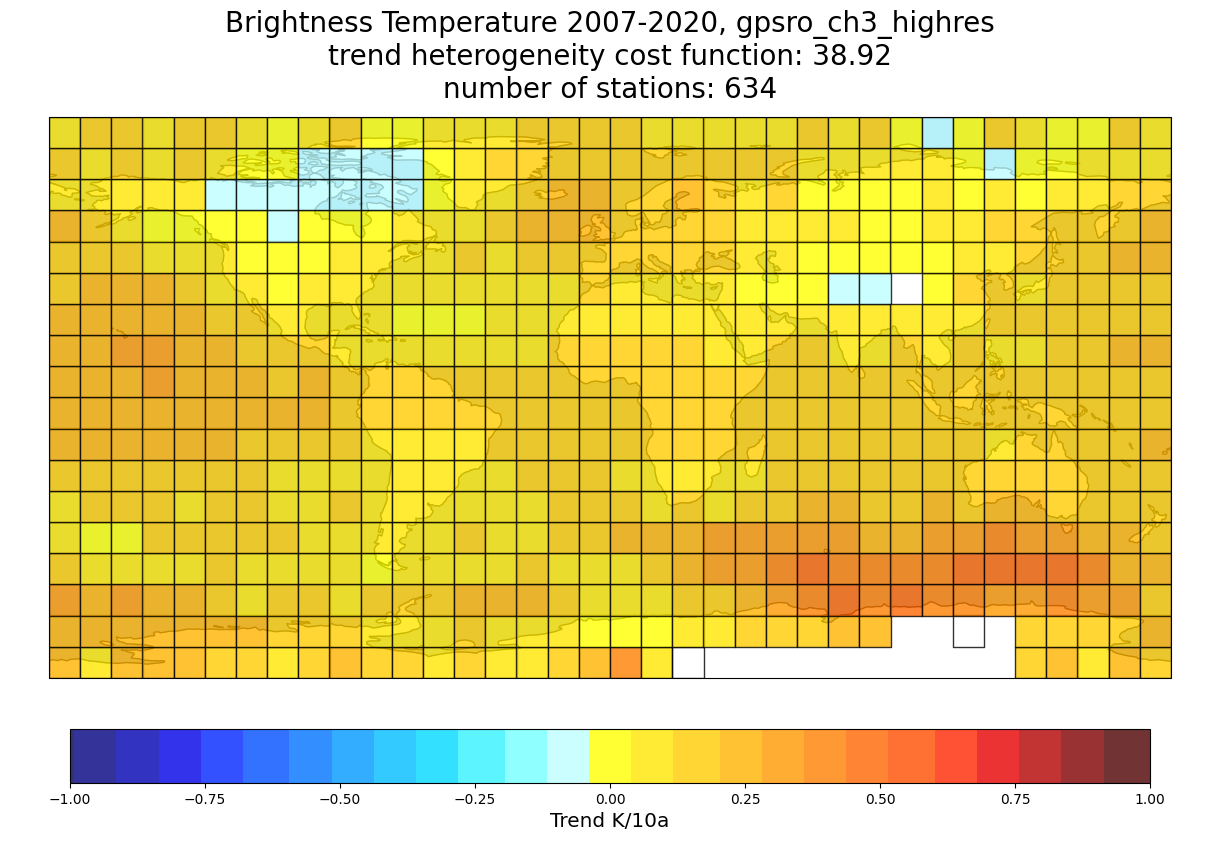

 --- dropped ---
[]
[]


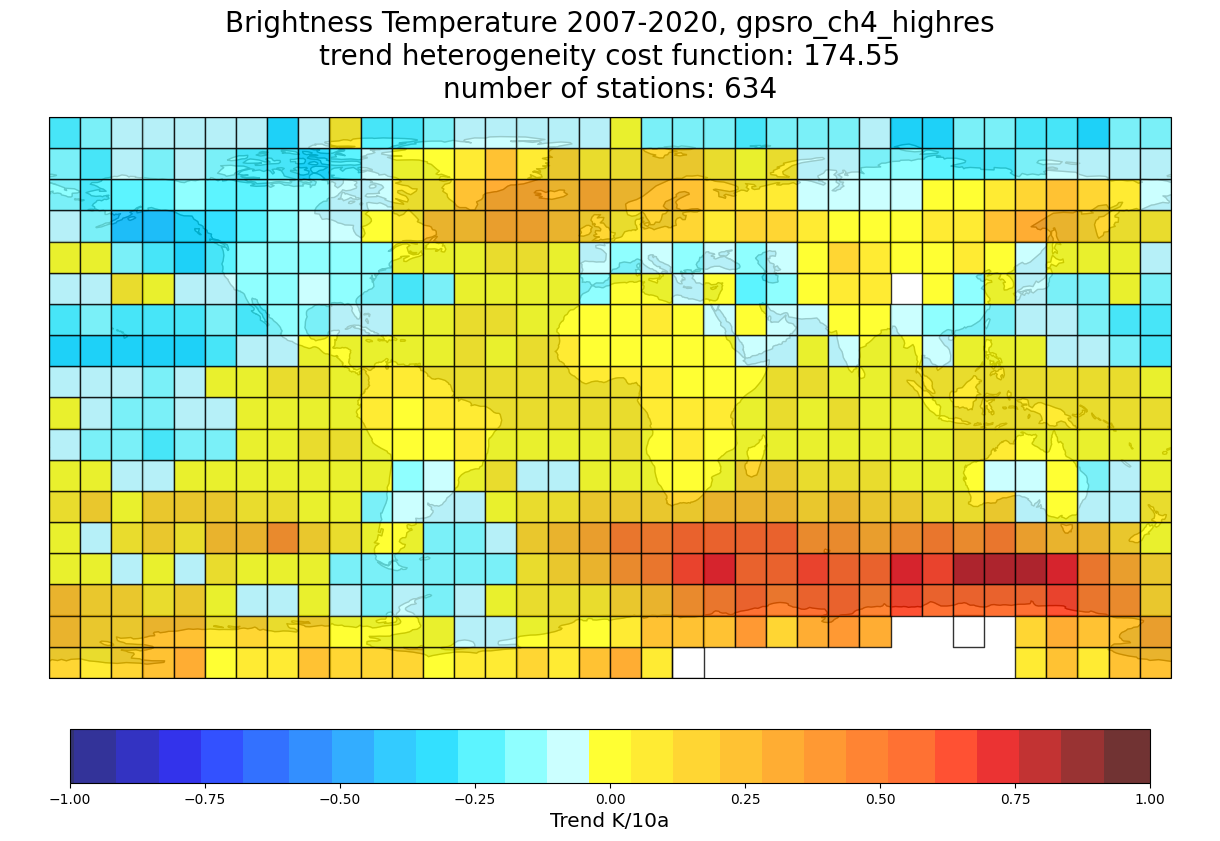

In [17]:
for k in ['ch2', 'ch3', 'ch4']:
    files = glob.glob('/users/staff/uvoggenberger/scratch/RTTOV_output/gpsro_worldmap/*'+k+'_highres.p')
    files = np.sort(files)
    for i in files:
        plot_world_map(i, i.split('/')[-1].split('.')[0])


In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.researchgate.net/publication/288057091/figure/fig1/AS:614162849878021@1523439242142/The-weighting-functions-for-the-satellite-Microwave-Sounding-Unit-MSU-and-the.png")

In [3]:
Image(url= "https://images.remss.com/figures/measurements/upper-air-temperature/wt_func_plot_for_web_2012.all_channels2.png")

In [3]:
for i in ['tlt', 'tmt', 'tls',]:
    files = glob.glob('/users/staff/leo/fastscratch/MSUUAHDaten/'+i+'*6.0')
    files = np.sort(files)
    print(i)
    print(files[0], files[-1])
    print(len(files), len(files)*12)
    print()

tlt
/users/staff/leo/fastscratch/MSUUAHDaten/tltmonamg.1978_6.0 /users/staff/leo/fastscratch/MSUUAHDaten/tltmonamg.2022_6.0
45 540

tmt
/users/staff/leo/fastscratch/MSUUAHDaten/tmtmonamg.1978_6.0 /users/staff/leo/fastscratch/MSUUAHDaten/tmtmonamg.2022_6.0
45 540

tls
/users/staff/leo/fastscratch/MSUUAHDaten/tlsmonamg.1978_6.0 /users/staff/leo/fastscratch/MSUUAHDaten/tlsmonamg.2022_6.0
45 540



In [4]:
with open(files[-1],"r") as myfile:
    data=(' -').join(myfile.read().split('-'))
    data=data.split('\n')
    dl=(len(data)-1)//649
    for i in range(dl,-1,-1):
        dum= data.pop(i*649)
    data=' '.join(data)
    c=np.fromstring(data,sep=' ')

print(np.shape(c))
c

(124416,)


array([-9999., -9999., -9999., ..., -9999., -9999., -9999.])

In [5]:
## why does a later startyear not work??
## why is it 12 longer than endyear should make it?
# 2.5° resolution
uah_data = rasotools.additions.allrasotrends.read_uah('/users/staff/leo/fastscratch/MSUUAHDaten/', '6.0',startyear=1978, endyear=2020)[0]
print(np.shape(uah_data))

('read_uah: ', 0.11554121971130371)
(4, 516, 72, 144)


In [6]:
## channel 2 is always nan?
display(uah_data[2,348:,3,3])

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [7]:
lats = np.array(range(-900,+925, 25))/10.
lats = lats[lats != 0]
print(len(lats), lats)
lons = np.array(range(0, 3600, 25))/10.
print(len(lons), lons)

72 [-90.  -87.5 -85.  -82.5 -80.  -77.5 -75.  -72.5 -70.  -67.5 -65.  -62.5
 -60.  -57.5 -55.  -52.5 -50.  -47.5 -45.  -42.5 -40.  -37.5 -35.  -32.5
 -30.  -27.5 -25.  -22.5 -20.  -17.5 -15.  -12.5 -10.   -7.5  -5.   -2.5
   2.5   5.    7.5  10.   12.5  15.   17.5  20.   22.5  25.   27.5  30.
  32.5  35.   37.5  40.   42.5  45.   47.5  50.   52.5  55.   57.5  60.
  62.5  65.   67.5  70.   72.5  75.   77.5  80.   82.5  85.   87.5  90. ]
144 [  0.    2.5   5.    7.5  10.   12.5  15.   17.5  20.   22.5  25.   27.5
  30.   32.5  35.   37.5  40.   42.5  45.   47.5  50.   52.5  55.   57.5
  60.   62.5  65.   67.5  70.   72.5  75.   77.5  80.   82.5  85.   87.5
  90.   92.5  95.   97.5 100.  102.5 105.  107.5 110.  112.5 115.  117.5
 120.  122.5 125.  127.5 130.  132.5 135.  137.5 140.  142.5 145.  147.5
 150.  152.5 155.  157.5 160.  162.5 165.  167.5 170.  172.5 175.  177.5
 180.  182.5 185.  187.5 190.  192.5 195.  197.5 200.  202.5 205.  207.5
 210.  212.5 215.  217.5 220.  222.5 225.  22

In [8]:
# create date var -> days since 2007-01-01
print(len(uah_data[3,348:,10, 10]), len(np.array(range(len(uah_data[3,348:,10, 10])))))
display(np.array(range(len(uah_data[3,348:,10, 10])))*30)

168 168


array([   0,   30,   60,   90,  120,  150,  180,  210,  240,  270,  300,
        330,  360,  390,  420,  450,  480,  510,  540,  570,  600,  630,
        660,  690,  720,  750,  780,  810,  840,  870,  900,  930,  960,
        990, 1020, 1050, 1080, 1110, 1140, 1170, 1200, 1230, 1260, 1290,
       1320, 1350, 1380, 1410, 1440, 1470, 1500, 1530, 1560, 1590, 1620,
       1650, 1680, 1710, 1740, 1770, 1800, 1830, 1860, 1890, 1920, 1950,
       1980, 2010, 2040, 2070, 2100, 2130, 2160, 2190, 2220, 2250, 2280,
       2310, 2340, 2370, 2400, 2430, 2460, 2490, 2520, 2550, 2580, 2610,
       2640, 2670, 2700, 2730, 2760, 2790, 2820, 2850, 2880, 2910, 2940,
       2970, 3000, 3030, 3060, 3090, 3120, 3150, 3180, 3210, 3240, 3270,
       3300, 3330, 3360, 3390, 3420, 3450, 3480, 3510, 3540, 3570, 3600,
       3630, 3660, 3690, 3720, 3750, 3780, 3810, 3840, 3870, 3900, 3930,
       3960, 3990, 4020, 4050, 4080, 4110, 4140, 4170, 4200, 4230, 4260,
       4290, 4320, 4350, 4380, 4410, 4440, 4470, 45

In [9]:
time_series = {}
for targetlon in lons:
    for targetlat in lats:
        time_series[str(targetlat) + '_' + str(targetlon)] = [[],[],[],[]]

for lat in range(len(lats)):
    for lon in range(len(lons)):
        ts_index = str(float(lats[lat])) + '_' + str(float(lons[lon]))
        time_series[ts_index][0] = uah_data[0,348:,lat, lon] 
        time_series[ts_index][1] = uah_data[1,348:,lat, lon] 
        time_series[ts_index][2] = uah_data[3,348:,lat, lon] 
        time_series[ts_index][3] = np.array(range(len(uah_data[3,348:,10, 10])))*30

trends_ch3 = {}
trends_ch4 = {}
trends_ch5 = {}
for lat_lon in time_series.keys():
    if len(time_series[lat_lon][0]) < 1:
        continue
    df = pandas.DataFrame(np.transpose(
        [np.array(time_series[lat_lon][0]).flatten(), 
         np.array(time_series[lat_lon][1]).flatten(), 
         np.array(time_series[lat_lon][2]).flatten(), 
         np.array(time_series[lat_lon][3]).flatten(), 
         [float(lat_lon.split('_')[0])]*len(time_series[lat_lon][0]), 
         [float(lat_lon.split('_')[1])]*len(time_series[lat_lon][0])]
         ), columns=['ch3', 'ch4', 'ch5', 'time', 'lat', 'lon'])
    df.time = [pd.to_datetime('2007-01-01') + pd.Timedelta(x, 'd') for x in df.time]
    # df.replace(-99.99, np.nan, inplace=True)
    # filter_array = np.abs(df.ch3 - df.ch4) < 0.5
    # df.ch3[filter_array] = np.nan
    # df.ch4[filter_array] = np.nan
    # df.ch5[filter_array] = np.nan
    df = df.dropna()

    xdf = df.set_index(['lat', 'lon', 'time']).to_xarray()
    trends_ch3[lat_lon] = (rasotools.met.time.trend(xdf.ch3, only_slopes=True, method='polyfit')*len(df.time)*12.*10.)
    trends_ch4[lat_lon] = (rasotools.met.time.trend(xdf.ch4, only_slopes=True, method='polyfit')*len(df.time)*12.*10.)
    trends_ch5[lat_lon] = (rasotools.met.time.trend(xdf.ch5, only_slopes=True, method='polyfit')*len(df.time)*12.*10.)

pickle.dump( trends_ch3, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/uah_worldmap/uah_ch2.p", "wb" ) )
pickle.dump( trends_ch4, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/uah_worldmap/uah_ch3.p", "wb" ) )
pickle.dump( trends_ch5, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/uah_worldmap/uah_ch4.p", "wb" ) )

 --- dropped ---
[]
[]


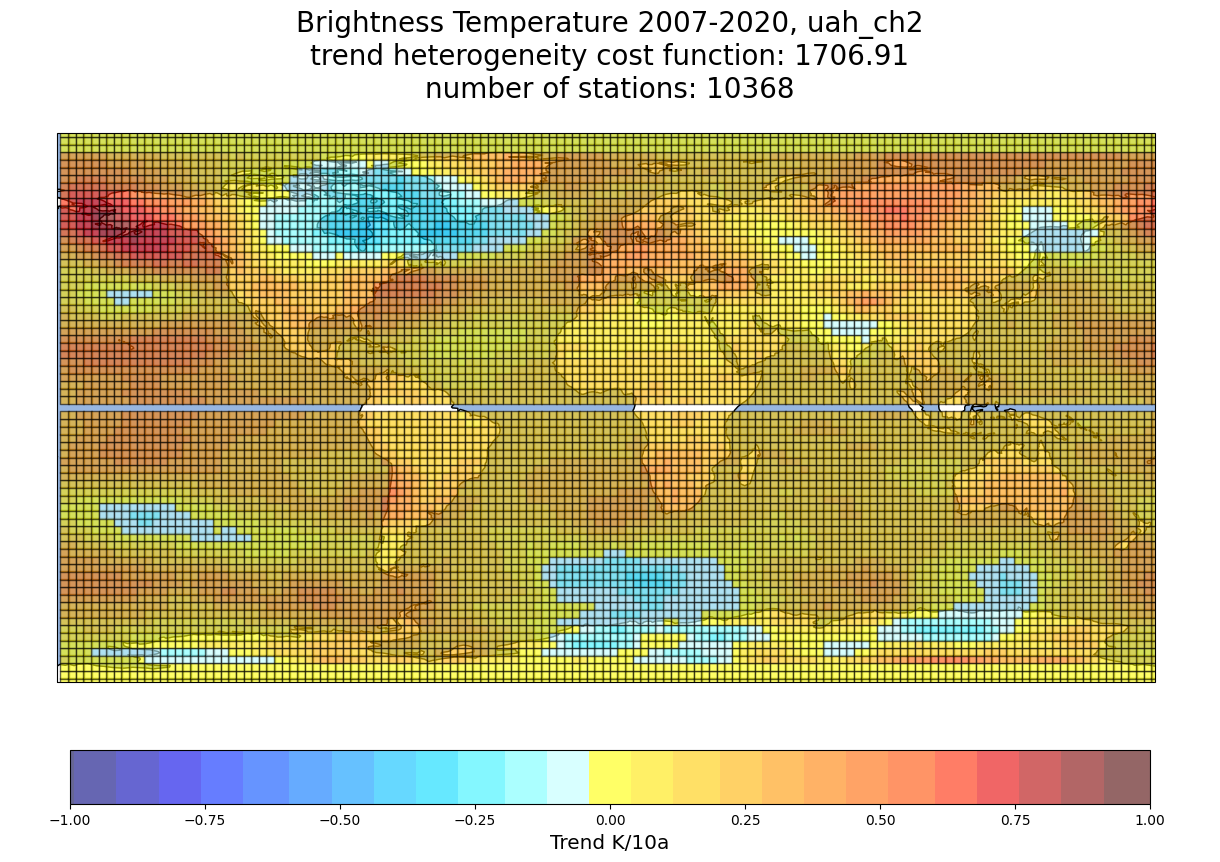

 --- dropped ---
[]
[]


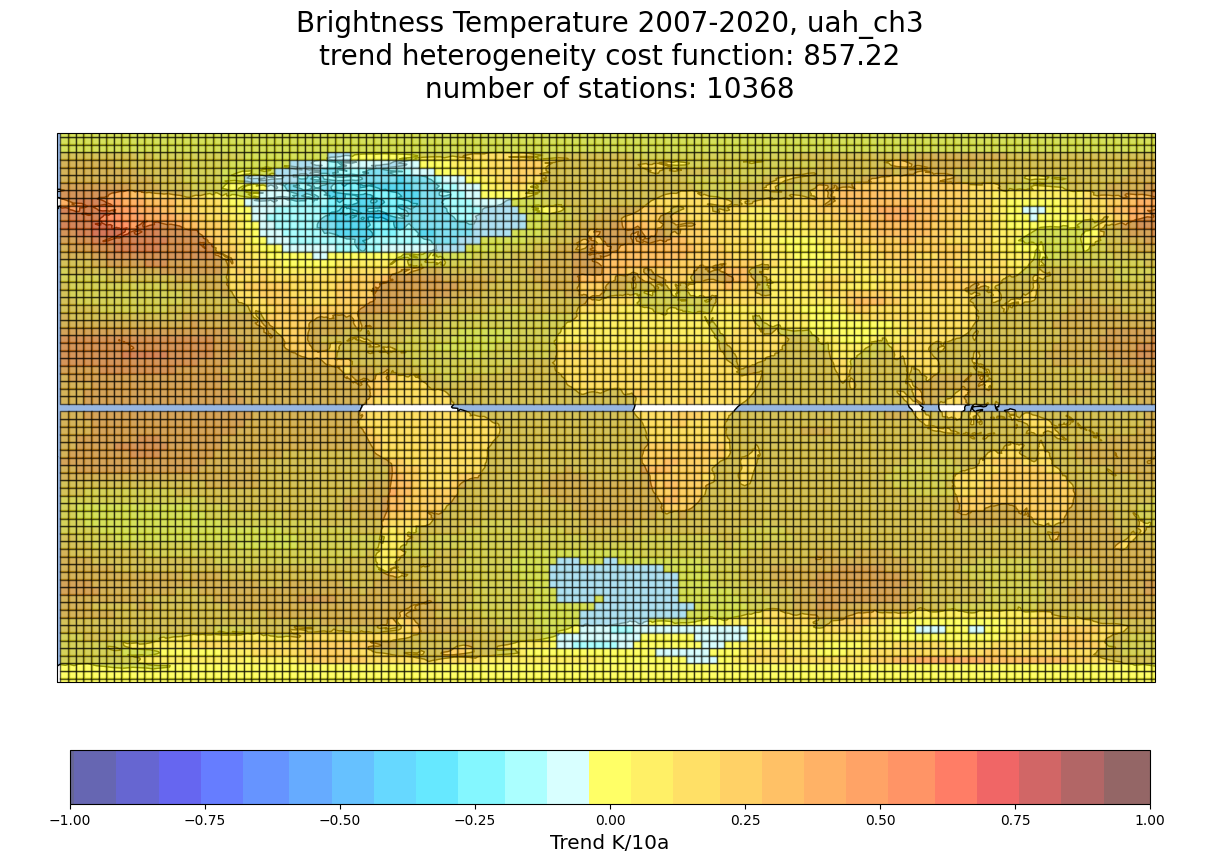

 --- dropped ---
[]
[]


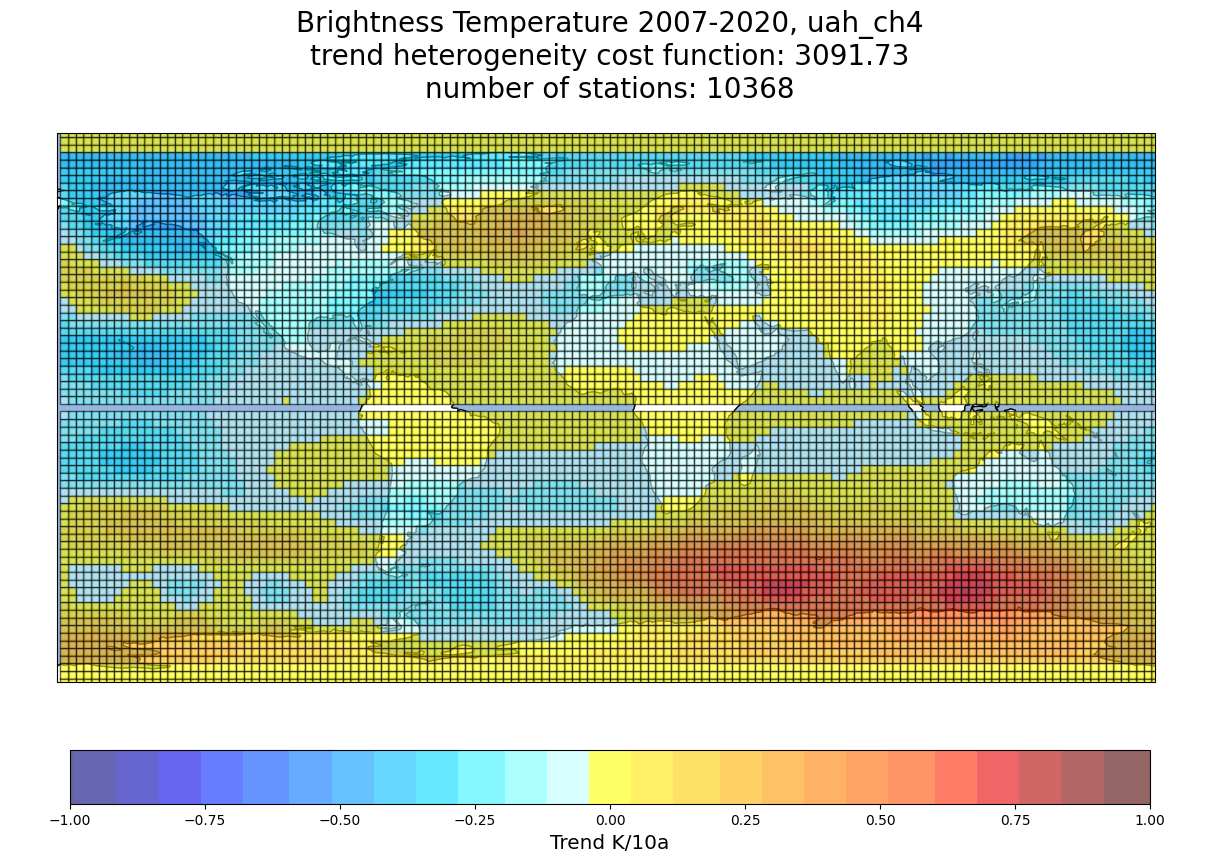

In [23]:
for k in ['ch2', 'ch3', 'ch4']:
    files = glob.glob('/users/staff/uvoggenberger/scratch/RTTOV_output/uah_worldmap/*'+k+'.p')
    files = np.sort(files)
    for i in files:
        plot_world_map(i, i.split('/')[-1].split('.')[0], marker_size = 35, marker_shape = 's', alpha = 0.6 )